# _**Figure 4.1** Count of ILCDx Data Instances per ILCDx Dataset included in the analysis_

In [32]:
import sqlite3
import pandas as pd
import json

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# Connect to the database and fetch each document's classification_system and JSON
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

query = """
    SELECT 
        COALESCE(lower(m.classification_system), 'no explicit classification') AS classification_system,
        d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# Define accepted broad category terms (all lower case)
broad_terms = {"construction products, infrastructure & buildings", "construction products"}

# Process each row to determine its category type: "Broad Category", "Missing", or "Adequate"
records = []
for raw_cs, doc_str in rows:
    cs = raw_cs  # classification system from the metadata (already lowercased)
    cat_type = "Missing"  # default assumption
    try:
        doc = json.loads(doc_str)
    except Exception:
        doc = {}

    try:
        classes = doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"]
        # Try to get the level 0 value
        candidate = None
        for item in classes:
            if item.get("level", None) == 0:
                candidate = item
                break
        if candidate is None and classes:
            candidate = classes[0]
        if candidate:
            val = candidate.get("value", "").strip()
            if not val:
                cat_type = "Missing"
            elif val.lower() in broad_terms:
                cat_type = "Broad Category"
            else:
                cat_type = "Adequate"
        else:
            cat_type = "Missing"
    except Exception:
        cat_type = "Missing"
    
    records.append({
        "classification_system": cs,
        "cat_type": cat_type
    })

# Create and cache the DataFrame with raw processed records
df_raw = pd.DataFrame(records)

# Optionally display the first few rows to verify the output
# df_raw.head()

# Optionally, save the DataFrame to a CSV file to avoid reprocessing in the future:
# df_raw.to_csv("processed_epd_data.csv", index=False)


<Figure size 1158.27x346.063 with 0 Axes>

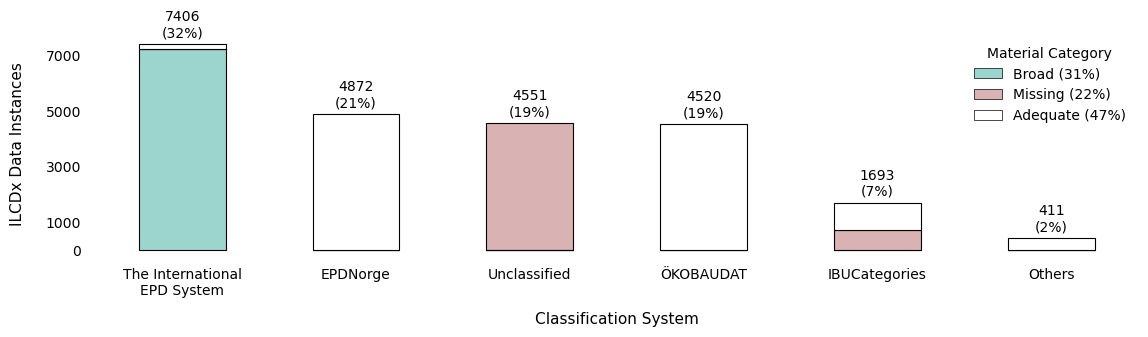

cat_type,Broad Category,Missing,Adequate
classification_system,,,
The International\nEPD System,7217.0,1.0,188.0
EPDNorge,0.0,0.0,4872.0
Unclassified,0.0,4551.0,0.0
ÖKOBAUDAT,0.0,6.0,4514.0
IBUCategories,0.0,699.0,994.0
Others,7.0,0.0,404.0


In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the renaming mapping for the classification system
rename_mapping = {
    "the international epd system": "The International EPD System",
    "epdnorge": "EPDNorge",
    "no explicit classification": "Unclassified",
    "oekobau.dat": "ÖKOBAUDAT",
    "ibucategories": "IBUCategories"
}
df_raw["classification_system"] = df_raw["classification_system"].replace(rename_mapping)

# 1. Aggregate counts by classification_system and cat_type
agg_df = df_raw.groupby(["classification_system", "cat_type"]) \
               .size() \
               .reset_index(name="epd_count")

# 2. Calculate total document count per classification system
totals = df_raw.groupby("classification_system") \
               .size() \
               .reset_index(name="total_count")

# Merge totals with the aggregated data and relabel systems with < 1000 as "Others"
agg_df = agg_df.merge(totals, on="classification_system", how="left")
low_systems = totals[totals["total_count"] < 1000]["classification_system"].tolist()
agg_df.loc[agg_df["classification_system"].isin(low_systems), "classification_system"] = "Others"

# 3. Re-aggregate after relabeling
final_df = agg_df.groupby(["classification_system", "cat_type"])["epd_count"] \
                 .sum() \
                 .reset_index()

# 4. Pivot the data for a stacked bar chart
pivot_df = final_df.pivot(index="classification_system", columns="cat_type", values="epd_count") \
                   .fillna(0)
pivot_df["Total"] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values("Total", ascending=False)
pivot_df = pivot_df.drop(columns="Total")

# 1. Define the custom color mapping using the provided colors. (presentation)
color_dict = {
    "Broad Category": "#9BD5CE",  # chosen from your palette
    "Missing":         "#D9B2B4",  # chosen from your palette
    "Adequate":        "white"     # chosen from your palette
}

# 1. Define the custom color mapping using the provided colors. (thesis)
color_dict = {
    "Broad Category": "#9BD5CE",  # chosen from your palette
    "Missing":         "#D9B2B4",  # chosen from your palette
    "Adequate":        "white"     # chosen from your palette
}

    # "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    # "#D9B2B4",  # dusty rose (Concrete class)
    # "#C2CBDF",  # lavender‐purple (Classification system)
    # "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    # "#BCCFB1",  # pale sage (BKI element)
    # "#C2FADB",  # light jade (Material category concept)
    # "#F1D6C1",  # peach sand (Canonical category)

# 2. Ensure pivot_df has the desired columns and order.
desired_order = ["Broad Category", "Missing", "Adequate"]
for col in desired_order:
    if col not in pivot_df.columns:
        pivot_df[col] = 0
pivot_df = pivot_df[desired_order]

# 3. Update the classification system label for two-line formatting.
pivot_df.rename(
    index={"The International EPD System": "The International\nEPD System"},
    inplace=True
)

# 4. Set the figure dimensions in inches (31.9 cm × 9.69 cm → inches).
fig_width = 29.42 / 2.54  # ~12.56 inches
fig_height = 8.79 / 2.54  # ~3.46 inches
fig = plt.figure(figsize=(fig_width, fig_height))

# 4. Set the figure dimentions in pixels (thesis)
# dpi = 100
# fig_width  = 1000 / dpi     # = 10.0 in
# fig_height =  432 / dpi     # = 4.32 in
# fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

# 5. Create the stacked bar chart.
ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(fig_width, fig_height),
    color=[color_dict[col] for col in desired_order],
    linewidth=0.8,
    edgecolor="black"
)

# 8. Annotate each stacked bar with total count and percent of overall.
totals = pivot_df.sum(axis=1)
grand_total = totals.sum()
for i, total in enumerate(totals):
    pct = total / grand_total * 100
    offset = totals.max() * 0.02
    ax.text(
        i,
        total + offset,
        f"{int(total)}\n({pct:.0f}%)",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Compute category-level percentages for the legend
category_totals = pivot_df.sum(axis=0)
grand_total_all = category_totals.sum()
b_pct = category_totals["Broad Category"] / grand_total_all * 100
m_pct = category_totals["Missing"]         / grand_total_all * 100
a_pct = category_totals["Adequate"]        / grand_total_all * 100

# Create custom legend handles with percentage in labels
broad_handle = mpatches.Patch(
    facecolor=color_dict["Broad Category"],
    edgecolor="black",
    linewidth=0.5,
    label=f"Broad ({b_pct:.0f}%)"
)
missing_handle = mpatches.Patch(
    facecolor=color_dict["Missing"],
    edgecolor="black",
    linewidth=0.5,
    label=f"Missing ({m_pct:.0f}%)"
)
adequate_handle = mpatches.Patch(
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    label=f"Adequate ({a_pct:.0f}%)"
)

# Update the legend without a border
plt.legend(
    handles=[broad_handle, missing_handle, adequate_handle],
    title="Material Category",
    frameon=False
)

# 9. Additional formatting.
ax.set_xlabel("Classification System", fontsize=11, labelpad=10)
ax.set_ylabel("ILCDx Data Instances",     fontsize=11, labelpad=15)
ax.tick_params(axis='both', which='both', length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

# Adjust bottom margin
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# Custom Y-ticks: 0, 1000, then every 2000 from 3000 upward
ymax = ax.get_ylim()[1]
custom_ticks = [0, 1000] + list(range(3000, int(ymax) + 1, 2000))
ax.set_yticks(custom_ticks)

# Optional: grid behind bars
# ax.set_axisbelow(True)
# plt.grid(axis="y", linestyle="-", alpha=0.3)

plt.xticks(rotation=0, ha="center", fontsize=10)
plt.tight_layout()
plt.savefig("data/img/4.1_count_ILCDx_instances.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# Optionally display the pivoted DataFrame
pivot_df


# _**Figure 4.2** Too broad or missing ILCD material categories across ILCDx Data Instances from The International EPD System_

In [29]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from collections import defaultdict

# Define path to EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# Fetch documents classified under the International EPD System
conn = sqlite3.connect(DB_PATH)
query = """
    SELECT d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    WHERE lower(m.classification_system) = 'the international epd system'
"""
rows = conn.execute(query).fetchall()
conn.close()

# Count categories (JSON path: processInformation...classification[0].class)
raw_counts = defaultdict(int)
for (doc_str,) in rows:
    try:
        doc = json.loads(doc_str)
        classes = (doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"])
        # sort levels and extract values
        classes_sorted = sorted(classes, key=lambda x: x.get("level", 0))
        vals = [c.get("value", "").strip() for c in classes_sorted if c.get("value", "").strip()]
        if vals:
            category = " > ".join(vals)
            raw_counts[category] += 1
    except Exception:
        continue

# Threshold small categories into 'Other'
THRESHOLD = 200
other_total = sum(cnt for cnt in raw_counts.values() if cnt < THRESHOLD)
counts = {cat: cnt for cat, cnt in raw_counts.items() if cnt >= THRESHOLD}
if other_total:
    counts['Other'] = other_total

# Build DataFrame and compute percentages
df = pd.DataFrame(list(counts.items()), columns=["category", "epd_count"])
total = df['epd_count'].sum()
df['percentage'] = (df['epd_count'] / total * 100).round(2)
df = df.sort_values(by='epd_count', ascending=False).reset_index(drop=True)


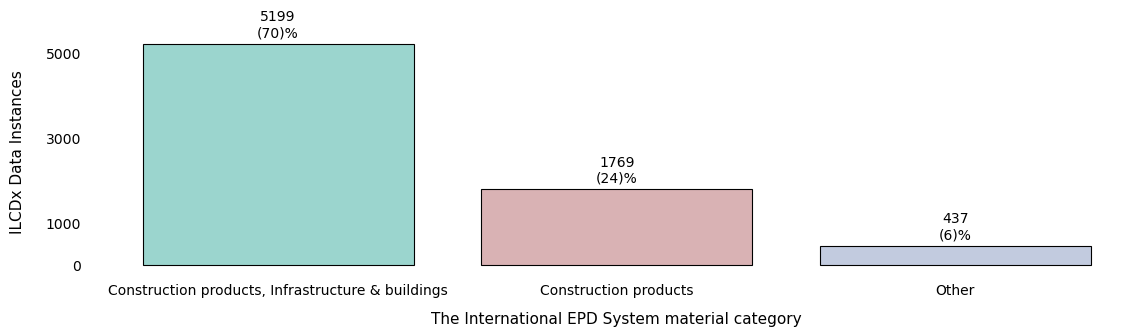

                                            category  epd_count  percentage
0  Construction products, Infrastructure & buildings       5199       70.21
1                              Construction products       1769       23.89
2                                              Other        437        5.90


In [30]:
# Prepare colour map
categories = df["category"].tolist()
#  Tweaked original 12‑colour palette (presentation)
# extended_palette = [
#     "#D4CF3A",  # vivid chartreuse (kept)
#     "#C9A326",  # richer gold (tweaked)
#     "#F1A208",  # vibrant amber (replaces muddy brown)
#     "#BFD833",  # lime/moss (tweaked)
#     "#7FB800",  # bright green (tweaked from 9ab206)
#     "#2E7D32",  # lively dark green (lightened 526f03)
#     "#00441B",  # forest green (accent)
#     "#2A9D8F",  # teal accent
#     "#E9C46A",  # sand yellow accent
#     "#BC4749",  # brick red accent
#     "#577590",  # blue accent
#     "#81B29A",  # sage accent
# ]

# Color-blind palette for thesis
# extended_palette = [
#     "#00441B",  # dark forest green
#     "#2A9D8F",  # teal
#     "#8CB369",  # moss green
#     "#F4A261",  # earth orange
#     "#E9C46A",  # sand yellow
#     "#264653",  # deep blue‑green
#     "#BC4749",  # brick red
#     "#6A994E",  # olive green
#     "#577590",  # desaturated blue
#     "#FFB5A7",  # soft coral
#     "#3D405B",  # slate blue
#     "#81B29A",  # sage green
# ]
# Color-blind palette for thesis
extended_palette = [
    "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    "#D9B2B4",  # dusty rose (Concrete class)
    "#C2CBDF",  # lavender‐purple (Classification system)
    "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    "#BCCFB1",  # pale sage (BKI element)
    "#C2FADB",  # light jade (Material category concept)
    "#F1D6C1",  # peach sand (Canonical category)
]

colour_map = {st: extended_palette[i] for i, st in enumerate(categories)}

# Plot
fig_width = 29.42 / 2.54  # ≈12.56 in
fig_height = 8.79 / 2.54  # ≈3.46 in
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Set the figure dimentions in pixels (thesis)
# dpi = 100
# fig_width  = 1000 / dpi     # = 10.0 in
# fig_height =  432 / dpi     # = 4.32 in
# fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

bars = ax.bar(
    df["category"],
    df["epd_count"],
    color=[colour_map[cat] for cat in df["category"]],
    edgecolor="black",
    linewidth=0.8,
)

# Annotate counts
for rect in bars:
    h = rect.get_height()
    pct = h / total * 100
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        h + df['epd_count'].max() * 0.02,  # vertical offset above the bar
        f"{int(h)}\n({pct:.0f})%",  # two lines: count then percent
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Styling
ax.set_xlabel(
    "The International EPD System material category", fontsize=11, labelpad=10
)
ax.set_ylabel("ILCDx Data Instances", fontsize=11, labelpad=15)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis="x", pad=10)
ax.tick_params(axis="y", pad=10)
ax.set_ylim(0, df["epd_count"].max() * 1.05)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# Custom Y-ticks: 0, 1000, then every 2000 from 3000 upward
ymax = ax.get_ylim()[1]
custom_ticks = [0, 1000] + list(range(3000, int(ymax) + 1, 2000))
ax.set_yticks(custom_ticks)

plt.xticks(rotation=0, ha="center", fontsize=10)
plt.tight_layout()
plt.savefig("data/img/4.2_ILCD_mat_cat_TIES.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Display results
print(df)

# _**Figure 4.3** Distribution of regex-based categorization in The International EPD System_

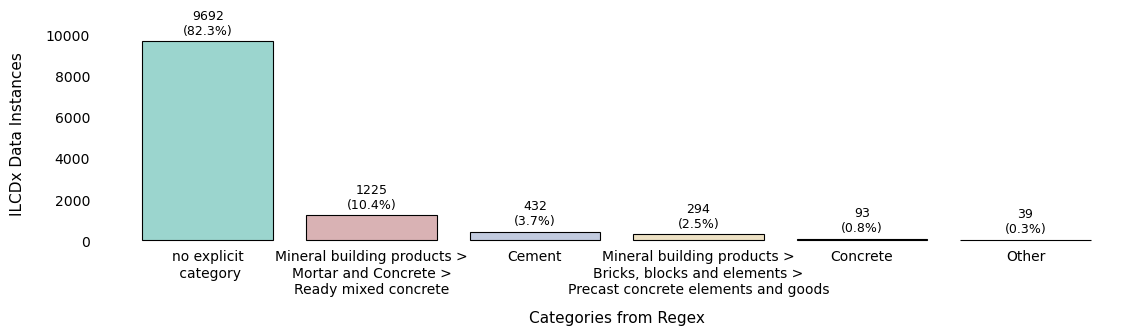

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data
file_path = "../data/pipeline2/sql/regex_classified/filtered_epd_data02_classified_all_05.csv"
df = pd.read_csv(file_path)

# 2. Count each RegEx classification
counts = df["RegEx Classification"].value_counts()
df_counts = counts.reset_index()
df_counts.columns = ["Category", "Count"]

# 2a. Rename the original “Other” to “no explicit category”
df_counts["Category"] = df_counts["Category"] \
    .replace({"Other": "no explicit\n category"})

# 3. Group small counts (<90) into “Other”
threshold = 90
major = df_counts[df_counts["Count"] >= threshold].copy()
minor = df_counts[df_counts["Count"] <  threshold].copy()
other_count = minor["Count"].sum()

df_plot = pd.concat([
    major,
    pd.DataFrame([{"Category": "Other", "Count": other_count}])
], ignore_index=True) \
  .sort_values("Count", ascending=False) \
  .reset_index(drop=True)

# 4. Compute percentages
total = df_plot["Count"].sum()
df_plot["Percent"] = df_plot["Count"] / total * 100

# 5. Build multiline labels
def multiline(label):
    if label in ("Other", "no explicit category"):
        return label
    return " >\n".join(label.split(" > "))

df_plot["Label"] = df_plot["Category"].apply(multiline)

# 6. Prepare colors and figure
# colors = [
#     "#F1EB4F","#D3B427","#B6A123","#9BAD1C",
#     "#7B9216","#5C7610","#3E580B","#253904",
#     "#161F03","#141C03","#121902",
# ]

# Color-blind palette for thesis
colors = [
    "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    "#D9B2B4",  # dusty rose (Concrete class)
    "#C2CBDF",  # lavender‐purple (Classification system)
    "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    "#BCCFB1",  # pale sage (BKI element)
    "#C2FADB",  # light jade (Material category concept)
    "#F1D6C1",  # peach sand (Canonical category)

]


fig_w = 29.42 / 2.54  # ~12.56"
fig_h =  8.79 / 2.54  # ~3.46"
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Set the figure dimentions in pixels (thesis)
# dpi = 100
# fig_width  = 1000 / dpi     # = 10.0 in
# fig_height =  432 / dpi     # = 4.32 in
# fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

# 7. Plot vertical bars at explicit x positions
x = list(range(len(df_plot)))
bars = ax.bar(
    x,
    df_plot["Count"],
    color=[colors[i % len(colors)] for i in x],
    edgecolor="black",
    linewidth=0.8
)

# 8. Give 10% headroom so annotations aren’t clipped
max_count = df_plot["Count"].max()
ax.set_ylim(0, max_count * 1.1)

# 9. Set xticks & labels (no rotation)
ax.set_xticks(x)
ax.set_xticklabels(df_plot["Label"], rotation=0, ha="center")

# 10. Axis labels
ax.set_xlabel("Categories from Regex", fontsize=11, labelpad=10)
ax.set_ylabel("ILCDx Data Instances", fontsize=11, labelpad=15)

# 11. Clean up spines & ticks
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis="both", which="both", length=0)

# 12. Adjust y-axis to create a bit more bottom space
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# 13. Annotate each bar: count then percentage
offset = max_count * 0.02
for i, bar in enumerate(bars):
    h   = bar.get_height()
    pct = df_plot.loc[i, "Percent"]
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + offset,
        f"{int(h)}\n({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=9,
        clip_on=False
    )

# 14. Make room for multiline labels
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.savefig("data/img/4.3_cat_regex.pdf", format="pdf", bbox_inches="tight")
plt.show()


# _**Figure 4.4** Distribution of RAG-based categorization of “Concrete” regex-identified entries from The International EPD System_

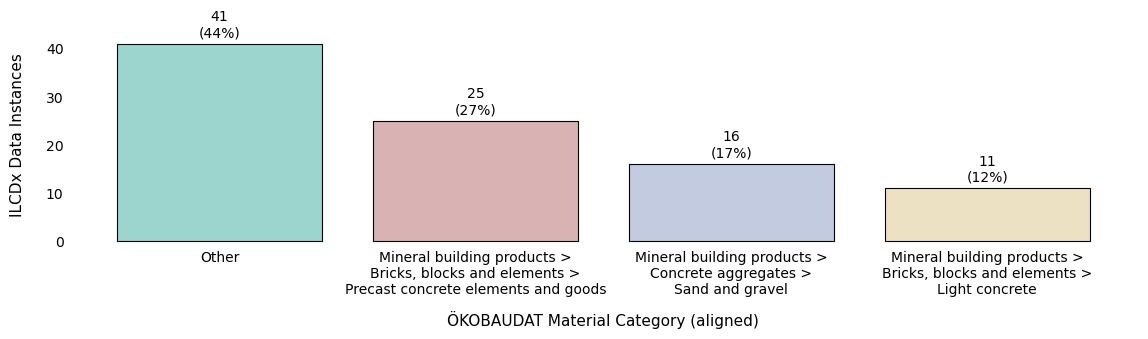

,Category,Count,Percent,label
0,Other,41,44.086022,Other
1,"Mineral building products > Bricks, blocks and...",25,26.881720,"Mineral building products >\nBricks, blocks an..."
2,Mineral building products > Concrete aggregate...,16,17.204301,Mineral building products >\nConcrete aggregat...
3,"Mineral building products > Bricks, blocks and...",11,11.827957,"Mineral building products >\nBricks, blocks an..."


In [26]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and extract best_category
categories = []
with open("../data/pipeline2/json/openai/batch_output_TIES_concrete_batch_6814cdb67bc08190902c4a7f1940df1d.jsonl", "r") as f:
    for line in f:
        entry = json.loads(line)
        content_str = entry["response"]["body"]["choices"][0]["message"]["content"]
        try:
            content = json.loads(content_str)
            cat = content.get("best_category")
            if cat:
                categories.append(cat)
        except json.JSONDecodeError:
            continue

# 2. Count and filter top 3 + Other
counts = Counter(categories)
top_cats = [
    "Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods",
    "Mineral building products > Concrete aggregates > Sand and gravel",
    "Mineral building products > Bricks, blocks and elements > Light concrete",
]
filtered = {}
other_sum = 0
for cat, cnt in counts.items():
    if cat in top_cats:
        filtered[cat] = cnt
    else:
        other_sum += cnt
filtered["Other"] = other_sum

# 3. Build DataFrame and sort descending by count
df = pd.DataFrame({
    "Category": list(filtered.keys()),
    "Count": list(filtered.values())
})
df = df.sort_values("Count", ascending=False).reset_index(drop=True)
df["Percent"] = df["Count"] / df["Count"].sum() * 100

# 4. Prepare palette after sorting
# extended_palette = [
#     "#D4CF3A", "#C9A326", "#F1A208", "#BFD833",
#     "#7FB800", "#2E7D32", "#00441B", "#2A9D8F",
#     "#E9C46A", "#BC4749", "#577590", "#81B29A",
# ]
# Color-blind palette for thesis
# extended_palette = [
#     "#00441B",  # dark forest green
#     "#2A9D8F",  # teal
#     "#8CB369",  # moss green
#     "#F4A261",  # earth orange
#     "#E9C46A",  # sand yellow
#     "#264653",  # deep blue‑green
#     "#BC4749",  # brick red
#     "#6A994E",  # olive green
#     "#577590",  # desaturated blue
#     "#FFB5A7",  # soft coral
#     "#3D405B",  # slate blue
#     "#81B29A",  # sage green
# ]

extended_palette = [
    "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    "#D9B2B4",  # dusty rose (Concrete class)
    "#C2CBDF",  # lavender‐purple (Classification system)
    "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    "#BCCFB1",  # pale sage (BKI element)
    "#C2FADB",  # light jade (Material category concept)
    "#F1D6C1",  # peach sand (Canonical category)

]
color_map = {cat: extended_palette[i] for i, cat in enumerate(df["Category"])}

# 5. Generate multi-line labels
df["label"] = df["Category"].apply(
    lambda x: x if x == "Other" else x.replace(" > ", " >\n")
)

# 6. Plot
fig_width = 29.42 / 2.54  # cm → inches
fig_height = 8.79 / 2.54
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Set the figure dimentions in pixels (thesis)
# dpi = 100
# fig_width  = 1000 / dpi     # = 10.0 in
# fig_height =  432 / dpi     # = 4.32 in
# fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

bars = ax.bar(
    df["label"],
    df["Count"],
    color=[color_map[cat] for cat in df["Category"]],
    edgecolor="black",
    linewidth=0.8
)

# 7. Annotate each bar: percentage in the middle, count on top
offset = df["Count"].max() * 0.02  # small gap for the count label
for rect, count, pct in zip(bars, df["Count"], df["Percent"]):
    x = rect.get_x() + rect.get_width() / 2
    h = rect.get_height()
    # percentage centered inside
    # ax.text(
    #     x, h / 2,
    #     f"{pct:.1f}%",
    #     ha="center", va="center",
    #     fontsize=9, color="black"
    # )
    # count above bar
    ax.text(
        x, h + offset,
        f"{int(count)}\n({pct:.0f}%)",
        ha="center", va="bottom",
        fontsize=10, color="black"
    )

# 8. Styling
ax.set_xlabel("ÖKOBAUDAT Material Category (aligned)", fontsize=11, labelpad=10)
ax.set_ylabel("ILCDx Data Instances", fontsize=11, labelpad=15)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(0, df["Count"].max() * 1.1)  # make room for the count labels
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

plt.xticks(rotation=0, ha="center")
plt.tight_layout()
plt.savefig("data/img/4.4_cat_regex_concrete.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Display the sorted DataFrame
df


In [ ]:
b

# _**Figure 4.5** Distribution of RAG-based categorization in EPDNorge_

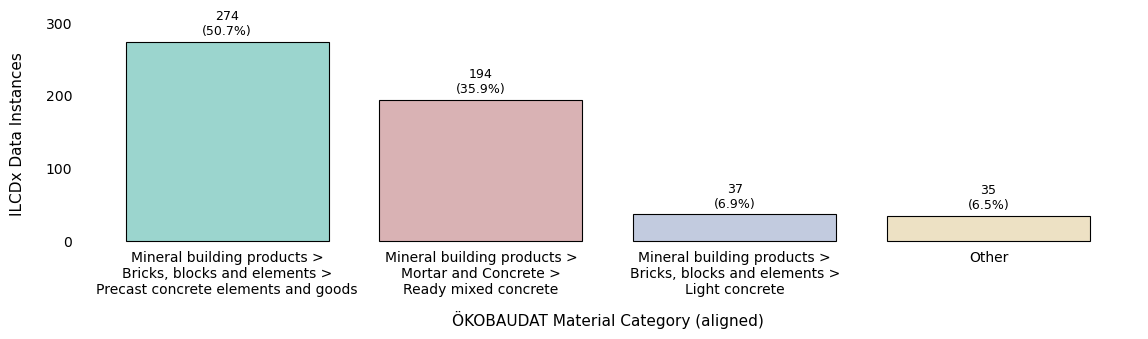

                                                                                     Category  Count   Percent                                                                                           label
Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods    274 50.740741 Mineral building products >\nBricks, blocks and elements >\nPrecast concrete elements and goods
                       Mineral building products > Mortar and Concrete > Ready mixed concrete    194 35.925926                        Mineral building products >\nMortar and Concrete >\nReady mixed concrete
                     Mineral building products > Bricks, blocks and elements > Light concrete     37  6.851852                      Mineral building products >\nBricks, blocks and elements >\nLight concrete
                                                                                        Other     35  6.481481                                                              

In [23]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and extract best_category
categories = []
with open("../data/pipeline2/json/openai/batch_output_EPDNorge_concrete_batch_6816185b6cc08190a28a2829a6c1f780.jsonl", "r") as f:
    for line in f:
        entry = json.loads(line)
        content_str = entry["response"]["body"]["choices"][0]["message"]["content"]
        try:
            content = json.loads(content_str)
            cat = content.get("best_category")
            if cat:
                categories.append(cat)
        except json.JSONDecodeError:
            continue

# 2. Count and pick the top 3 dynamically
counts = Counter(categories)
top3 = [cat for cat, _ in counts.most_common(3)]

# 3. Build filtered counts: keep those top3, lump everything else into "Other"
filtered = {}
other_sum = 0
for cat, cnt in counts.items():
    if cat in top3:
        filtered[cat] = cnt
    else:
        other_sum += cnt
filtered["Other"] = other_sum

# 4. Build DataFrame and sort descending by count
df = pd.DataFrame({
    "Category": list(filtered.keys()),
    "Count": list(filtered.values())
})
df = df.sort_values("Count", ascending=False).reset_index(drop=True)
df["Percent"] = df["Count"] / df["Count"].sum() * 100

# 5. Prepare color palette after sorting
# extended_palette = [
#     "#D4CF3A", "#C9A326", "#F1A208", "#BFD833",
#     "#7FB800", "#2E7D32", "#00441B", "#2A9D8F",
#     "#E9C46A", "#BC4749", "#577590", "#81B29A",
# ]
# Color-blind palette for thesis
# extended_palette = [
#     "#00441B",  # dark forest green
#     "#2A9D8F",  # teal
#     "#8CB369",  # moss green
#     "#F4A261",  # earth orange
#     "#E9C46A",  # sand yellow
#     "#264653",  # deep blue‑green
#     "#BC4749",  # brick red
#     "#6A994E",  # olive green
#     "#577590",  # desaturated blue
#     "#FFB5A7",  # soft coral
#     "#3D405B",  # slate blue
#     "#81B29A",  # sage green
# ]

# Color-blind palette for thesis
colors = [
    "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    "#D9B2B4",  # dusty rose (Concrete class)
    "#C2CBDF",  # lavender‐purple (Classification system)
    "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    "#BCCFB1",  # pale sage (BKI element)
    "#C2FADB",  # light jade (Material category concept)
    "#F1D6C1",  # peach sand (Canonical category)

]

color_map = {cat: extended_palette[i] for i, cat in enumerate(df["Category"])}

# 6. Multi‐line x‐labels
df["label"] = df["Category"].apply(
    lambda x: x if x == "Other" else x.replace(" > ", " >\n")
)

# 7. Plot
fig_w = 29.42 / 2.54  # cm → inches
fig_h = 8.79 / 2.54
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Set the figure dimentions in pixels (thesis)
# dpi = 100
# fig_width  = 1000 / dpi     # = 10.0 in
# fig_height =  432 / dpi     # = 4.32 in
# fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

bars = ax.bar(
    df["label"],
    df["Count"],
    color=[color_map[cat] for cat in df["Category"]],
    edgecolor="black",
    linewidth=0.8
)

# 8. Annotate each bar: count + percentage above
offset = df["Count"].max() * 0.02
for rect, count, pct in zip(bars, df["Count"], df["Percent"]):
    x = rect.get_x() + rect.get_width() / 2
    h = rect.get_height()
    ax.text(
        x, h + offset,
        f"{int(count)}\n({pct:.1f}%)",
        ha="center", va="bottom",
        fontsize=9, color="black"
    )

# 9. Styling
ax.set_xlabel("ÖKOBAUDAT Material Category (aligned)", fontsize=11, labelpad=10)
ax.set_ylabel("ILCDx Data Instances", fontsize=11, labelpad=15)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(0, df["Count"].max() * 1.1)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# set y‐ticks every 100 units from 0 up to the maximum
max_val = int(df["Count"].max() * 1.1)
ax.set_yticks(range(0, max_val + 1, 100))

plt.xticks(rotation=0, ha="center")
plt.tight_layout()
plt.savefig("data/img/4.5_ILCD_mat_cat_EPDN.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 10. (Optional) inspect the DataFrame
print(df.to_string(index=False))


# _**Figure 4.6** Top-k Accuracy per top performing embedding model across variants_

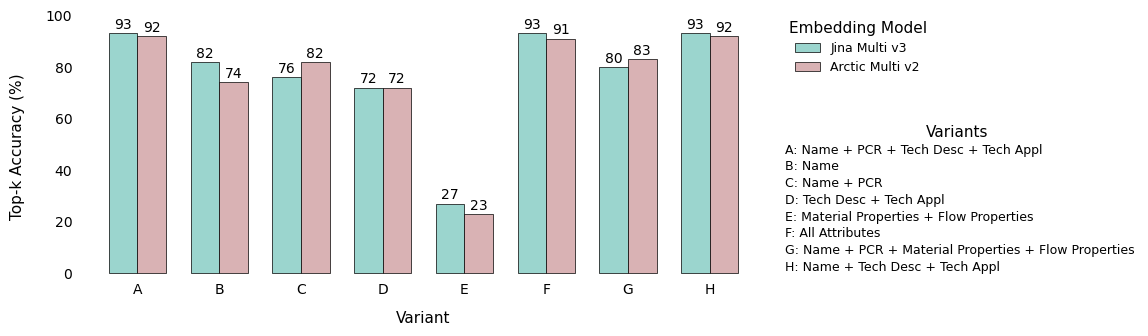

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. File paths and variant labels
file_paths = [
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_091834.csv",  # A
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_123814.csv",  # B
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_124404.csv",  # C
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_125703.csv",  # D
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_142154.csv",  # E
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_142809.csv",  # F
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_150612.csv",  # G
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_150906.csv",  # H
]
variants = list("ABCDEFGH")

# 2. Read and assemble Top-k Accuracy (%) for each model×variant
records = []
for path in file_paths:
    df = pd.read_csv(path)
    df["Top-k Accuracy"] = df["Top-k Accuracy"] * 100
    records.append(df.set_index("Embedding Model")["Top-k Accuracy"])
acc_df = pd.DataFrame(records, index=variants)

# 3. Consistent model order and short names
model_order = [
    "jinaai/jina-embeddings-v3",
    "snowflake-arctic-embed2:latest",
]
short_names = {
    "jinaai/jina-embeddings-v3": "Jina Multi v3",
    "snowflake-arctic-embed2:latest": "Arctic Multi v2",
}
acc_df = acc_df[model_order]

# 4. Styling
# colors = ["#D4CF3A", "#C9A326"]
colors = ["#F1EB4F", "#D3B427"] # presentation
colors = ["#2A9D8F", "#E9C46A"] # thesis
# Color-blind palette for thesis
colors = [
    "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    "#D9B2B4",  # dusty rose (Concrete class)
    "#C2CBDF",  # lavender‐purple (Classification system)
    "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    "#BCCFB1",  # pale sage (BKI element)
    "#C2FADB",  # light jade (Material category concept)
    "#F1D6C1",  # peach sand (Canonical category)

]

# Presentation
fig_width = 29.42 / 2.54  # ~12.56 in
fig_height = 8.79 / 2.54  # ~3.46 in

# Set the figure dimentions in pixels (thesis)
# dpi = 100
# fig_width  = 1000 / dpi     # = 10.0 in
# fig_height =  432 / dpi     # = 4.32 in
# fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

# 5. Plot bars
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
x = np.arange(len(variants))
bar_width = 0.35

for i, model in enumerate(model_order):
    heights = acc_df[model].values
    bars = ax.bar(
        x + i * bar_width,
        heights,
        width=bar_width,
        color=colors[i],
        edgecolor="black",
        linewidth=0.5,
        label=short_names[model]
    )
    for rect in bars:
        h = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            h + 0.5,
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=10
        )

# 6. Axes styling
ax.set_xlabel("Variant", fontsize=11, labelpad=10)
ax.set_ylabel("Top-k Accuracy (%)", fontsize=11, labelpad=15)
# ax.set_title("Top-k Accuracy per Embedding Model Across Variants", fontsize=12)
ax.set_xticks(x + bar_width * (len(model_order) - 1) / 2)
ax.set_xticklabels(variants, rotation=0)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(0, 100)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# 7. Embedding-model legend – move outside top‐right of the axes
embed_handles, embed_labels = ax.get_legend_handles_labels()
embed_legend = ax.legend(
    embed_handles,
    embed_labels,
    title="Embedding Model",
    loc="upper left",               # anchor legend's upper‐left corner
    bbox_to_anchor=(1.02, 1),      # just outside the axes (x, y) = (1.02, 1.0)
    borderaxespad=0,                 # no extra padding between axes and legend
    fontsize=9,
    title_fontsize=11,
    frameon=False,            # no border
)
ax.add_artist(embed_legend)

# 8. Variant descriptions legend
variant_descriptions = {
    "A": "Name + PCR + Tech Desc + Tech Appl",
    "B": "Name",
    "C": "Name + PCR",
    "D": "Tech Desc + Tech Appl",
    "E": "Material Properties + Flow Properties",
    "F": "All Attributes",
    "G": "Name + PCR + Material Properties + Flow Properties",
    "H": "Name + Tech Desc + Tech Appl",
}
variant_handles = [
    mpatches.Patch(color="none", label=f"{k}: {v}")
    for k, v in variant_descriptions.items()
]
variant_legend = ax.legend(
    handles=variant_handles,
    title="Variants",
    title_fontsize=11,      # smaller title
    fontsize=9,             # smaller labels
    labelspacing=0.3,       # less vertical space
    handlelength=0,         
    handletextpad=0.4,      
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1, 0.3),
    borderpad=0.3,          # padding around the legend box
    columnspacing=0.5,      # spacing between columns if you use ncol>1
    ncol=1,                  # or 2 if you want two narrow columns
)

plt.tight_layout()
plt.savefig("data/img/4.6_top_embed_variants.pdf", format="pdf", bbox_inches="tight")
plt.show()
